# Muskometer
## An NLP to anomalous behavior state classifier model for Elon Musk's (or any individual's) twitter usage history 
## by JJ Cherry [(@NeutrinoHalo)](https://twitter.com/NeutrinoHalo) for Insight DS20B

The basic idea of this project is to take historical tweet data from Elon Musk and use that to construct a model of his mood based on his twitter usage patterns.  That mood model will be used as a predictive feature of Tesla/SpaceX stock price change prediction modelling.

Let's start the exploration by reading in the historical data I grabbed from Kaggle:
- Elon Musk tweets from 2012 to 2017 https://www.kaggle.com/kulgen/elon-musks-tweets
- Tesla stock price data https://www.kaggle.com/rpaguirre/tesla-stock-price

In [1]:
import pandas as pd
import seaborn as sbn
import numpy as np
import datetime as datetime
from matplotlib import pyplot as plt
import re
from textblob import TextBlob

In [2]:
tweets_df = pd.read_csv('../datasets_2931_4935_data_elonmusk.csv', encoding='latin1')
tesla_stock_price_df = pd.read_csv('../datasets_1007_1814_Tesla.csv - Tesla.csv.csv')

In [34]:
tweets_df.head()

,row ID,Tweet,Time,Retweet from,User
0,Row0,@MeltingIce Assuming max acceleration of 2 to ...,2017-09-29 17:39:19,NaN,elonmusk
1,Row1,RT @SpaceX: BFR is capable of transporting sat...,2017-09-29 10:44:54,SpaceX,elonmusk
2,Row2,@bigajm Yup :),2017-09-29 10:39:57,NaN,elonmusk
3,Row3,Part 2 https://t.co/8Fvu57muhM,2017-09-29 09:56:12,NaN,elonmusk
4,Row4,Fly to most places on Earth in under 30 mins a...,2017-09-29 09:19:21,NaN,elonmusk


In [35]:
tweets_df.describe()

,row ID,Tweet,Time,Retweet from,User
count,3218,3218,3218,525,3218
unique,3218,3216,3217,201,1
top,Row2678,Best saying ever ?@temochdez: there is a sayin...,2013-07-24 10:49:13,SpaceX,elonmusk
freq,1,2,2,109,3218


In [36]:
tesla_stock_price_df.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,6/29/2010,19.000000,25.00,17.540001,23.889999,18766300,23.889999
1,6/30/2010,25.790001,30.42,23.299999,23.830000,17187100,23.830000
2,7/1/2010,25.000000,25.92,20.270000,21.959999,8218800,21.959999
3,7/2/2010,23.000000,23.10,18.709999,19.200001,5139800,19.200001
4,7/6/2010,20.000000,20.00,15.830000,16.110001,6866900,16.110001


In [37]:
tesla_stock_price_df.describe()

,Open,High,Low,Close,Volume,Adj Close
count,1692.000000,1692.000000,1692.000000,1692.000000,1.692000e+03,1692.000000
mean,132.441572,134.769698,129.996223,132.428658,4.270741e+06,132.428658
std,94.309923,95.694914,92.855227,94.313187,4.295971e+06,94.313187
min,16.139999,16.629999,14.980000,15.800000,1.185000e+05,15.800000
25%,30.000000,30.650000,29.214999,29.884999,1.194350e+06,29.884999
50%,156.334999,162.370002,153.150002,158.160004,3.180700e+06,158.160004
75%,220.557495,224.099999,217.119999,220.022503,5.662100e+06,220.022503
max,287.670013,291.420013,280.399994,286.040009,3.716390e+07,286.040009


Pretty bare bones stuff, but this should be enough to get us going with our data munging.  Let's begin with tidying up the tweet data to remove special characters and punctuation.

In [3]:
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"RT", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df

tweets_clean_df = standardize_text(tweets_df,"Tweet")
tweets_clean_df.to_csv('./clean_tweets.csv')
tweets_clean_df.head()

,row ID,Tweet,Time,Retweet from,User
0,Row0,"assuming max acceleration of 2 to 3 g's, but ...",2017-09-29 17:39:19,NaN,elonmusk
1,Row1,bfr is capable of transporting satellites to...,2017-09-29 10:44:54,SpaceX,elonmusk
2,Row2,yup ),2017-09-29 10:39:57,NaN,elonmusk
3,Row3,part 2,2017-09-29 09:56:12,NaN,elonmusk
4,Row4,fly to most places on earth in under 30 mins a...,2017-09-29 09:19:21,NaN,elonmusk


In [39]:
# Analyse tweet using TextBlob  'positive' > 0., 'negative'<0. or 'neutral'==0.
def get_tweet_sentiment(tweet):
    # create TextBlob object of passed tweet text
    tweet_analysis = TextBlob(tweet)
    return tweet_analysis.sentiment.polarity

In [40]:
tweets_clean_df['Sentiment'] = tweets_clean_df.apply(lambda row : get_tweet_sentiment(row['Tweet']), axis=1)

In [41]:
tweets_clean_df.describe()

,Sentiment
count,3218.000000
mean,0.127829
std,0.269016
min,-1.000000
25%,0.000000
50%,0.000000
75%,0.250000
max,1.000000


In [56]:
def get_tweet_sentiment_class(tweet_polarity):
    # set sentiment
    if tweet_polarity > 0.:
        return 'positive'
    elif tweet_polarity == 0.:
        return 'neutral'
    else:
        return 'negative'
tweets_clean_df['Class_Sentiment'] = tweets_clean_df.apply(lambda row : get_tweet_sentiment_class(row['Sentiment']), axis=1)

It seems that Mr. Musk is actually a net positive guy!  Let's continue cleaning.

In [42]:
# Drop unwanted columns
tweets_clean_df = tweets_clean_df.drop('row ID',1)
tweets_clean_df = tweets_clean_df.drop('User',1)

In [57]:
tweets_clean_df.head()

,Tweet,Time,Retweet from,Sentiment,delta_Time,Class_Sentiment
0,"assuming max acceleration of 2 to 3 g's, but ...",2017-09-29 17:39:19,NaN,0.366667,00:00:00,positive
1,bfr is capable of transporting satellites to...,2017-09-29 10:44:54,SpaceX,0.200000,-1 days +17:05:35,positive
2,yup ),2017-09-29 10:39:57,NaN,0.000000,-1 days +23:55:03,neutral
3,part 2,2017-09-29 09:56:12,NaN,0.000000,-1 days +23:16:15,neutral
4,fly to most places on earth in under 30 mins a...,2017-09-29 09:19:21,NaN,0.650000,-1 days +23:23:09,positive


Generate a feature that is the instantaneous tweet frequency

In [44]:
# Convert 'Time' column to datetime and strip time information.
tweets_clean_df['Time'] = pd.to_datetime(tweets_clean_df['Time'])#.dt.date
tweets_clean_df['Time']

0      2017-09-29 17:39:19
1      2017-09-29 10:44:54
2      2017-09-29 10:39:57
3      2017-09-29 09:56:12
4      2017-09-29 09:19:21
               ...        
3213   2012-11-20 08:52:03
3214   2012-11-20 08:38:31
3215   2012-11-20 08:30:44
3216   2012-11-19 08:59:46
3217   2012-11-16 17:59:47
Name: Time, Length: 3218, dtype: datetime64[ns]

In [52]:
np.timedelta64(1,'D')

numpy.timedelta64(1,'D')

In [104]:
tweets_clean_df['delta_Time'] = abs(pd.to_timedelta((tweets_clean_df['Time']-tweets_clean_df['Time'].shift()).fillna(0.)).astype('timedelta64[s]')).replace(0.,60.)
tweets_clean_df['log_delta_Time'] = np.log10(abs(pd.to_timedelta((tweets_clean_df['Time']-tweets_clean_df['Time'].shift()).fillna(0.)).astype('timedelta64[s]')).replace(0.,60.))

In [105]:
tweets_clean_df.head()

,Tweet,Time,Retweet from,Sentiment,delta_Time,Class_Sentiment,tokens,Tweet_Length,log_delta_Time
0,"assuming max acceleration of 2 to 3 g's, but ...",2017-09-29 17:39:19,NaN,0.366667,60.0,positive,"[assuming, max, acceleration, of, 2, to, 3, g,...",21,1.778151
1,bfr is capable of transporting satellites to...,2017-09-29 10:44:54,SpaceX,0.200000,24865.0,positive,"[bfr, is, capable, of, transporting, satellite...",20,4.395588
2,yup ),2017-09-29 10:39:57,NaN,0.000000,297.0,neutral,[yup],1,2.472756
3,part 2,2017-09-29 09:56:12,NaN,0.000000,2625.0,neutral,"[part, 2]",2,3.419129
4,fly to most places on earth in under 30 mins a...,2017-09-29 09:19:21,NaN,0.650000,2211.0,positive,"[fly, to, most, places, on, earth, in, under, ...",20,3.344589


Generate features that are the token words for each tweet and the total tweet length in words.

In [59]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
tweets_clean_df["tokens"] = tweets_clean_df["Tweet"].apply(tokenizer.tokenize)
tweets_clean_df['Tweet_Length'] = tweets_clean_df.apply(lambda row : len(row['tokens']), axis=1)
tweets_clean_df.head()

,Tweet,Time,Retweet from,Sentiment,delta_Time,Class_Sentiment,tokens,Tweet_Length
0,"assuming max acceleration of 2 to 3 g's, but ...",2017-09-29 17:39:19,NaN,0.366667,00:00:00,positive,"[assuming, max, acceleration, of, 2, to, 3, g,...",21
1,bfr is capable of transporting satellites to...,2017-09-29 10:44:54,SpaceX,0.200000,-1 days +17:05:35,positive,"[bfr, is, capable, of, transporting, satellite...",20
2,yup ),2017-09-29 10:39:57,NaN,0.000000,-1 days +23:55:03,neutral,[yup],1
3,part 2,2017-09-29 09:56:12,NaN,0.000000,-1 days +23:16:15,neutral,"[part, 2]",2
4,fly to most places on earth in under 30 mins a...,2017-09-29 09:19:21,NaN,0.650000,-1 days +23:23:09,positive,"[fly, to, most, places, on, earth, in, under, ...",20


let's plot some exploratory data

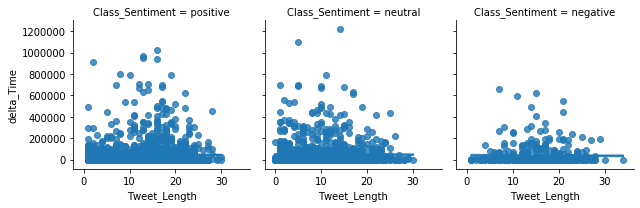

In [84]:
#Elon's Tweets Scatter plots looking at delta time
facet = sns.FacetGrid(tweets_clean_df,col='Class_Sentiment')
facet.map(sbn.regplot,'Tweet_Length','delta_Time')

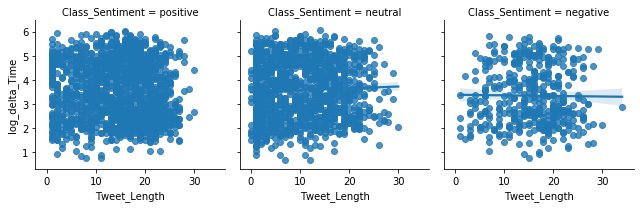

In [86]:
#Elon's Tweets Scatter plots looking at log_delta_time
facet = sns.FacetGrid(tweets_clean_df,col='Class_Sentiment')
facet.map(sbn.regplot,'Tweet_Length','log_delta_Time')

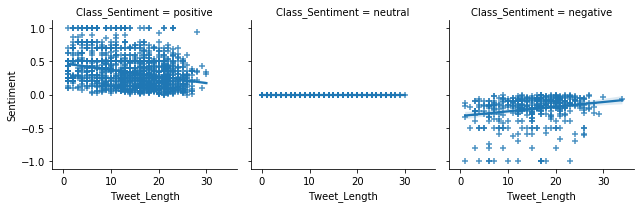

In [89]:
#Elon's Tweets Scatter plots
facet = sns.FacetGrid(tweets_clean_df,col='Class_Sentiment')
facet.map(sbn.regplot,'Tweet_Length','Sentiment',marker="+")

/Users/JJ/opt/anaconda3/envs/insight/lib/python3.8/site-packages/numpy/core/function_base.py:153: RuntimeWarning: invalid value encountered in multiply
  y *= step
/Users/JJ/opt/anaconda3/envs/insight/lib/python3.8/site-packages/numpy/core/function_base.py:163: RuntimeWarning: invalid value encountered in add
  y += start
/Users/JJ/opt/anaconda3/envs/insight/lib/python3.8/site-packages/numpy/linalg/linalg.py:1965: RuntimeWarning: invalid value encountered in greater
  large = s > cutoff


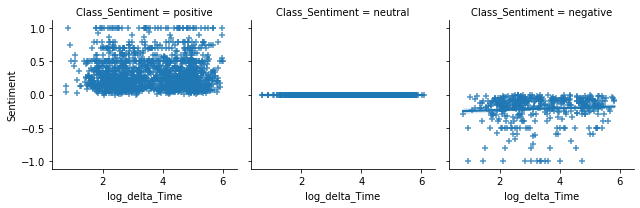

In [90]:
#Elon's Tweets Scatter plots
facet = sns.FacetGrid(tweets_clean_df,col='Class_Sentiment')
facet.map(sbn.regplot,'log_delta_Time','Sentiment',marker="+")

Nothing particularly illuminating there other than the observation that more terse tweets tend to have higher sentiment scores.

In [114]:
#Make a rate of sentiment change feature
tweets_clean_df['dSentiment_dTime'] = (tweets_clean_df['Sentiment']-tweets_clean_df['Sentiment'].shift(-1)).fillna(0.)/(tweets_clean_df['delta_Time'])
tweets_clean_df['dSentiment_dTweet'] = (tweets_clean_df['Sentiment']-tweets_clean_df['Sentiment'].shift(-1)).fillna(0.)
tweets_clean_df.tail()

,Tweet,Time,Retweet from,Sentiment,delta_Time,Class_Sentiment,tokens,Tweet_Length,log_delta_Time,dSentiment_dTime,dSentiment_dTweet
3213,"amos's article was fair, but his editor chose...",2012-11-20 08:52:03,NaN,0.466667,45026.0,positive,"[amos, s, article, was, fair, but, his, editor...",23,4.653463,0.000010,0.466667
3214,these articles in space news describe why aria...,2012-11-20 08:38:31,NaN,0.000000,812.0,neutral,"[these, articles, in, space, news, describe, w...",12,2.909556,0.000000,0.000000
3215,was misquoted by bbc as saying europe's rocket...,2012-11-20 08:30:44,NaN,0.000000,467.0,neutral,"[was, misquoted, by, bbc, as, saying, europe, ...",27,2.669317,-0.000892,-0.416667
3216,just returned from a trip to london and oxford...,2012-11-19 08:59:46,NaN,0.416667,84658.0,positive,"[just, returned, from, a, trip, to, london, an...",20,4.927668,0.000005,0.416667
3217,my model s just arrived and i went electric ...,2012-11-16 17:59:47,Jon_Favreau,0.000000,226799.0,neutral,"[my, model, s, just, arrived, and, i, went, el...",12,5.355641,0.000000,0.000000


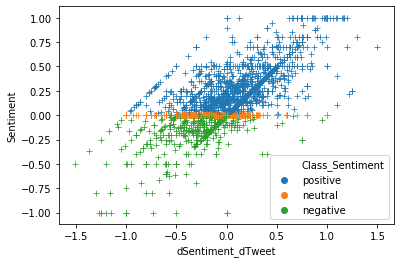

In [125]:
#Elon's Tweets Scatter plots
#facet = sns.FacetGrid(tweets_clean_df,hue='Class_Sentiment')
#facet.map(sbn.scatterplot,'dSentiment_dTweet','Sentiment',marker="+")
sbn.scatterplot(x = tweets_clean_df['dSentiment_dTweet'],y=tweets_clean_df['Sentiment'],hue=tweets_clean_df['Class_Sentiment'],data=tweets_clean_df,marker = '+')

In [127]:
tweets_clean_df.groupby(['Class_Sentiment'])[['dSentiment_dTweet','dSentiment_dTime','delta_Time']].agg(np.mean).reset_index() #proper indices

,Class_Sentiment,dSentiment_dTweet,dSentiment_dTime,delta_Time
0,negative,-0.328019,-0.001795,37936.405152
1,neutral,-0.122319,-0.000442,48344.198565
2,positive,0.191164,0.000728,49964.620690


In [128]:
tweets_clean_df.groupby(['Class_Sentiment'])[['dSentiment_dTweet','dSentiment_dTime','delta_Time']].agg(np.median).reset_index()

,Class_Sentiment,dSentiment_dTweet,dSentiment_dTime,delta_Time
0,negative,-0.256818,-0.00010,1404.0
1,neutral,0.000000,0.00000,4004.5
2,positive,0.187500,0.00001,3401.0


In [129]:
tweets_clean_df.groupby(['Class_Sentiment'])[['dSentiment_dTweet','dSentiment_dTime','delta_Time']].agg(np.var).reset_index()

,Class_Sentiment,dSentiment_dTweet,dSentiment_dTime,delta_Time
0,negative,0.114480,0.000049,7.922909e+09
1,neutral,0.068434,0.000013,1.241363e+10
2,positive,0.124168,0.000015,1.315573e+10


In [147]:
tweets_clean_df.groupby('Class_Sentiment').Time.nunique()

Class_Sentiment
negative    279
neutral     588
positive    655
Name: Time, dtype: int64

Let's prep the data for direct comparison to the stock data.  First I'll define a few functions to use.

In [136]:
from pandas.tseries.offsets import BDay #import the business day function

def filter_by_daterange(df): # filters to only use business day tweets (stocks are reported only on business days)
    start_date = pd.to_datetime("2012-1-1").date()
    end_date = pd.to_datetime("2017-12-31").date()
    mask = (df['Time'] > start_date) & (df['Time'] <= end_date)
    df = df.loc[mask]
    #Filter only Business day
    isBusinessDay = BDay().onOffset
    match_series = pd.to_datetime(df['Time']).map(isBusinessDay)
    df[match_series]
    return df

def clean_tweet_data(tweets): # filters and sorts the tweets
    # Convert 'Time' column to datetime and strip time information.
    tweets['Time'] = pd.to_datetime(tweets['Time']).dt.date
    #apply the business day filter
    tweets = filter_by_daterange(tweets)
    #sort by date
    tweets.sort_values(by=['Time'], inplace=True)
    return tweets

def clean_stock_data(stonks): # extracts and sorts the fractional price change in tesla's stock price
    #Remove null stock data.
    stonks = stonks.dropna()
    #Convert 'Date' column to datetime and strip time information.
    stonks['Time'] = pd.to_datetime(stonks['Date']).dt.date
    stonks = stonks.drop('Date',1)
    #Apply the Business day filter, just to be safe
    stonks = filter_by_daterange(stonks)    
    #Calculate daily change percentage
    stonks['daily_percentage_change'] = (stonks['Close'] - stonks['Open']) / stonks['Open'] * 100
    stonks_daily_change = stonks[['Time', 'daily_percentage_change']].copy()
    #Make sure we are sorted identically to the tweet data
    stonks_daily_change.sort_values(by=['Time'], inplace=True)
    return stonks_daily_change

def merge_tweets_and_stock_data(tweets, stocks): #bolts our two dataframes together
    #Combine two dataframes based on time.
    sentiment_stock_change_data = pd.merge(tweets, stocks, on='Time', how='inner')
    return sentiment_stock_change_data

tweets_premerge_df = clean_tweet_data(tweets_clean_df)
stocks_premerge_df = clean_stock_data(tesla_stock_price_df)

In [137]:
tweets_and_stocks_df = merge_tweets_and_stock_data(tweets_premerge_df,stocks_premerge_df)

In [138]:
tweets_and_stocks_df.head()

,Tweet,Time,Retweet from,Sentiment,delta_Time,Class_Sentiment,tokens,Tweet_Length,log_delta_Time,dSentiment_dTime,dSentiment_dTweet,daily_percentage_change
0,my model s just arrived and i went electric ...,2012-11-16,Jon_Favreau,0.000000,226799.0,neutral,"[my, model, s, just, arrived, and, i, went, el...",12,5.355641,0.000000,0.000000,2.215088
1,just returned from a trip to london and oxford...,2012-11-19,NaN,0.416667,84658.0,positive,"[just, returned, from, a, trip, to, london, an...",20,4.927668,0.000005,0.416667,2.650446
2,these articles in space news describe why aria...,2012-11-20,NaN,0.000000,812.0,neutral,"[these, articles, in, space, news, describe, w...",12,2.909556,0.000000,0.000000,0.609759
3,"btw, i don't think apple is doomed just won't...",2012-11-20,NaN,0.000000,18253.0,neutral,"[btw, i, don, t, think, apple, is, doomed, jus...",21,4.261334,0.000013,0.234375,0.609759
4,was misquoted by bbc as saying europe's rocket...,2012-11-20,NaN,0.000000,467.0,neutral,"[was, misquoted, by, bbc, as, saying, europe, ...",27,2.669317,-0.000892,-0.416667,0.609759


Let's add a null classifier for each day, so that we can see the shape of a true random distribution relative to daily change.  We're doing this because we expect the histogram of truly random tweeting to be biased toward positive daily percentage change (as tesla's stock price increase by a factor of 11 over this time period).

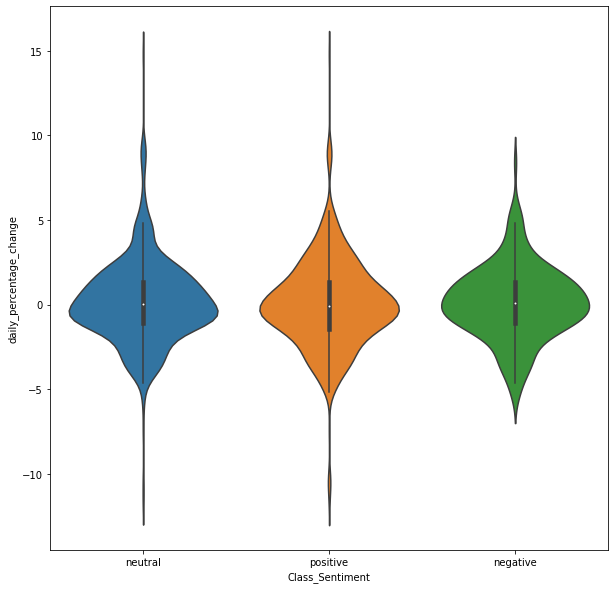

In [142]:
plt.figure(figsize=(10, 10))
sbn.violinplot(x=tweets_and_stocks_df.Class_Sentiment, y=tweets_and_stocks_df.daily_percentage_change, data=tweets_and_stocks_df, height=8)

# Let's try running the NLP with VADER to see if we get a different answer.

In [7]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon') #get the bloody lexicon

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/JJ/nltk_data...


True

In [8]:
sid = SentimentIntensityAnalyzer() #returns error if no lexicon

In [9]:
tweets_clean_df.head()

,row ID,Tweet,Time,Retweet from,User
0,Row0,"assuming max acceleration of 2 to 3 g's, but ...",2017-09-29 17:39:19,NaN,elonmusk
1,Row1,bfr is capable of transporting satellites to...,2017-09-29 10:44:54,SpaceX,elonmusk
2,Row2,yup ),2017-09-29 10:39:57,NaN,elonmusk
3,Row3,part 2,2017-09-29 09:56:12,NaN,elonmusk
4,Row4,fly to most places on earth in under 30 mins a...,2017-09-29 09:19:21,NaN,elonmusk


In [10]:
tweets_clean_df.Tweet[0]

" assuming max acceleration of 2 to 3 g's, but in a comfortable direction  will feel like a mild to moder? "

In [16]:
for tweet in tweets_clean_df.Tweet:
    print (tweet)

 assuming max acceleration of 2 to 3 g's, but in a comfortable direction  will feel like a mild to moder? 
  bfr is capable of transporting satellites to orbit, crew and cargo to the  and completing missions to the moon an?
 yup  )
part 2 
fly to most places on earth in under 30 mins and anywhere in under 60  cost per seat should be? 
  supporting the creation of a permanent, self sustaining human presence on mars   
bfr will take you anywhere on earth in less than 60 mins 
mars city
opposite of earth  dawn and dusk sky are blue on mars and day sky is red  
moon base alpha 
will be announcing something really special at today's talk 
  nine years ago today, falcon 1 became the first privately developed liquid fuel rocket to orbit earth  
 just another day in the office
  congrats mom! i love you 
    i'm so excited to say that i'm now officially a covergirl, at 69! beauty is for all ages   covergirlmade 
prev ideas for paying   10b dev cost incl  kickstarter   collecting underpants, wh

In [21]:
for tweet in tweets_clean_df.head().Tweet:
    ps = sid.polarity_scores(tweet)
    print(ps)

{'neg': 0.0, 'neu': 0.645, 'pos': 0.355, 'compound': 0.8271}
{'neg': 0.0, 'neu': 0.88, 'pos': 0.12, 'compound': 0.3818}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


In [22]:
def apply_vader(tweet,category): #gives back the float value of the vader sentiment
    return sid.polarity_scores(tweet)[category]

In [23]:
v_cats = ['neg','neu','pos','compound']

In [24]:
for cat in v_cats: #iterates over the 
    tweets_clean_df['v_'+cat] = tweets_clean_df.apply(lambda row : apply_vader(row['Tweet'],cat), axis=1)

In [26]:
tweets_clean_df.head(15)

,row ID,Tweet,Time,Retweet from,User,v_neg,v_neu,v_pos,v_compound
0,Row0,"assuming max acceleration of 2 to 3 g's, but ...",2017-09-29 17:39:19,NaN,elonmusk,0.0,0.645,0.355,0.8271
1,Row1,bfr is capable of transporting satellites to...,2017-09-29 10:44:54,SpaceX,elonmusk,0.0,0.880,0.120,0.3818
2,Row2,yup ),2017-09-29 10:39:57,NaN,elonmusk,0.0,1.000,0.000,0.0000
3,Row3,part 2,2017-09-29 09:56:12,NaN,elonmusk,0.0,1.000,0.000,0.0000
4,Row4,fly to most places on earth in under 30 mins a...,2017-09-29 09:19:21,NaN,elonmusk,0.0,1.000,0.000,0.0000
5,Row5,"supporting the creation of a permanent, self...",2017-09-29 08:57:29,SpaceX,elonmusk,0.0,0.643,0.357,0.6124
6,Row6,bfr will take you anywhere on earth in less th...,2017-09-29 08:53:00,NaN,elonmusk,0.0,1.000,0.000,0.0000
7,Row7,mars city\nopposite of earth dawn and dusk sk...,2017-09-29 06:03:32,NaN,elonmusk,0.0,1.000,0.000,0.0000
8,Row8,moon base alpha,2017-09-29 05:44:55,NaN,elonmusk,0.0,1.000,0.000,0.0000
9,Row9,will be announcing something really special at...,2017-09-29 02:36:17,NaN,elonmusk,0.0,0.728,0.272,0.4576
